#### Data Loading and Exploration

##### Import required libraries

In [2]:
###basic python librarries 
import os      ###for folder path operation 
import warnings           #to ignore warning message
warnings.filterwarnings('ignore')


In [3]:
## Data Manipulation and analysis
import pandas as pd
import numpy as np

In [4]:
#### Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
#### Exploratory Data Analysis
#statistical summary 
from scipy import stats 
from scipy.stats import skew,kurtosis

In [6]:
##display setting
pd.set_option('display.max_columns',None)
pd.set_option('display.width',1000)

In [7]:
pip install psycopg2-binary

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.



In [8]:
### postgreSQL connect library
import psycopg2
from sqlalchemy import create_engine

In [9]:
print("Finally every required libraries are imported")

Finally every required libraries are imported


#### Load all csv files

In [10]:
Folder_path=r"C:\Users\Asus\OneDrive\Desktop\Board_game postgrsql project\data"

In [11]:
#Main games file
board_games=pd.read_csv(os.path.join(Folder_path,"board_games.csv"))
##Topics and LDA outputs
board_topics=pd.read_csv(os.path.join(Folder_path,"bgg_topics.csv"))
board_ldaOut_topics=pd.read_csv(os.path.join(Folder_path,"bgg_ldaOut_topics.csv"))
board_ldaOut_top_terms=pd.read_csv(os.path.join(Folder_path,"bgg_ldaOut_top_terms.csv"))
board_ldaOut_top_documents=pd.read_csv(os.path.join(Folder_path,"bgg_ldaOut_top_documents.csv"))

In [12]:
for name,df in {
    "Board_games":board_games,
    "Board_topics":board_topics,
    "Board_ldaOut_topics":board_ldaOut_topics,
    "Board_ldaOut_top_terms":board_ldaOut_top_terms,
    "Board_ldaOut_top_documents":board_ldaOut_top_documents
}.items():
    print(f"---{name}---")
    print(df.shape)
    print(df.isnull().sum())
    print(df.columns)
    print()

---Board_games---
(90400, 81)
row_names                                   0
game.id                                     0
game.type                                   0
details.description                        27
details.image                            6892
                                        ...  
stats.family.commodore64.pos            90399
stats.subtype.rpgitem.bayesaverage      90396
stats.subtype.rpgitem.pos               90398
stats.subtype.videogame.bayesaverage    90399
stats.subtype.videogame.pos             90399
Length: 81, dtype: int64
Index(['row_names', 'game.id', 'game.type', 'details.description', 'details.image', 'details.maxplayers', 'details.maxplaytime', 'details.minage', 'details.minplayers', 'details.minplaytime', 'details.name', 'details.playingtime', 'details.thumbnail', 'details.yearpublished', 'attributes.boardgameartist', 'attributes.boardgamecategory', 'attributes.boardgamecompilation', 'attributes.boardgamedesigner', 'attributes.boardgameexpansion', 

In [13]:
board_games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90400 entries, 0 to 90399
Data columns (total 81 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   row_names                                 90400 non-null  int64  
 1   game.id                                   90400 non-null  int64  
 2   game.type                                 90400 non-null  object 
 3   details.description                       90373 non-null  object 
 4   details.image                             83508 non-null  object 
 5   details.maxplayers                        90397 non-null  float64
 6   details.maxplaytime                       90397 non-null  float64
 7   details.minage                            90397 non-null  float64
 8   details.minplayers                        90397 non-null  float64
 9   details.minplaytime                       90397 non-null  float64
 10  details.name                      

In [14]:
### In the board_games table , i had used only a subseset of essential columns that are most suitable for 
# ETL and analysis.Out of the total 81 columns ,i did not select allbecause many are sparse,textual,or not required for numeric and categorical analysis 
#this approach ensures efficient data processing and focused insights

In [15]:
###Essential cols only
col_essential=['game.id', 'details.name', 'details.yearpublished', 'details.minplayers','details.maxplayers', 'details.minage', 'details.playingtime',
    'stats.average', 'stats.bayesaverage', 'stats.usersrated', 'stats.averageweight','attributes.boardgamepublisher']
###Rename for clarity 
games_df=board_games[col_essential].copy()
games_df.columns=['game_id','name','year_published','min_players','max_players','min_age','playing_time','average_rating','bayes_average','num_ratings','complexity','publisher']

In [16]:
#check shape
print(games_df.shape)

(90400, 12)


##### Missing Value Handling (Numeric + Categorical)

In [17]:
#Numeric cols---median
numeric_cols=['year_published','min_players','max_players','min_age','playing_time','average_rating','bayes_average','num_ratings','complexity']
for col in numeric_cols:
    games_df[col].fillna(games_df[col].median(),inplace=True)


In [18]:
### Categorical/Text --filled with unknown 
categorical_cols = ['name', 'publisher']

for col in categorical_cols:
    games_df[col].fillna('Unknown', inplace=True)

# Check missing values
print(games_df.isnull().sum())

game_id           0
name              0
year_published    0
min_players       0
max_players       0
min_age           0
playing_time      0
average_rating    0
bayes_average     0
num_ratings       0
complexity        0
publisher         0
dtype: int64


##### Normality check for numeric ones

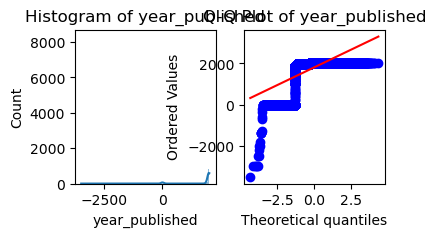

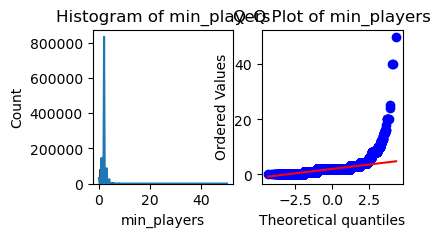

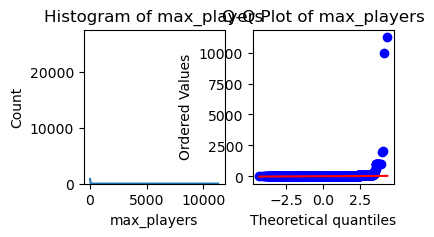

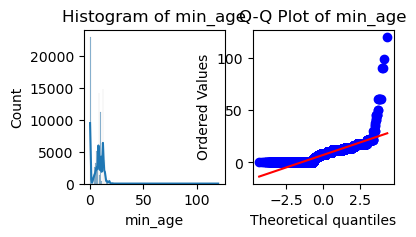

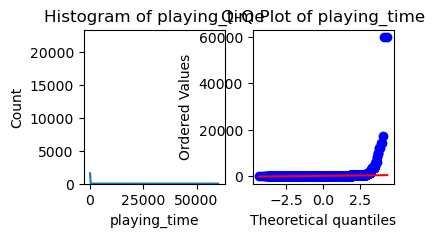

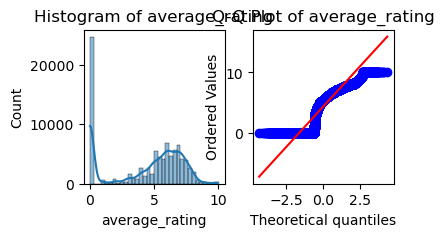

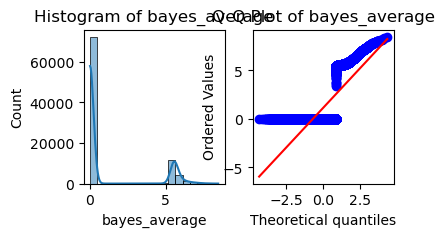

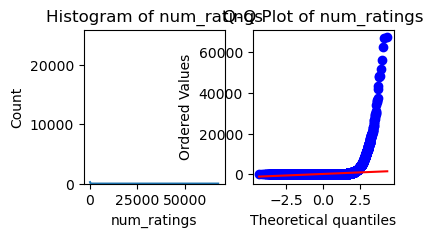

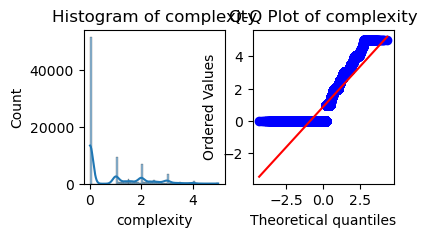

In [19]:
for col in numeric_cols:
    plt.figure(figsize=(4,2))
    
    plt.subplot(1,2,1)
    sns.histplot(games_df[col], kde=True)
    plt.title(f'Histogram of {col}')
    
    plt.subplot(1,2,2)
    stats.probplot(games_df[col], dist="norm", plot=plt)
    plt.title(f'Q-Q Plot of {col}')
    
    plt.show()

In [20]:
#### Outlier Detection using IQR
for col in numeric_cols:
    Q1 = games_df[col].quantile(0.25)
    Q3 = games_df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = games_df[(games_df[col] < lower) | (games_df[col] > upper)]
    print(f'{col} → Outliers: {outliers.shape[0]} rows')


year_published → Outliers: 11044 rows
min_players → Outliers: 23929 rows
max_players → Outliers: 2281 rows
min_age → Outliers: 22 rows
playing_time → Outliers: 5278 rows
average_rating → Outliers: 0 rows
bayes_average → Outliers: 18063 rows
num_ratings → Outliers: 14556 rows
complexity → Outliers: 473 rows


In [21]:
#### Outlier Handling(IQR Capping/Winsorization) ## if exists
for col in numeric_cols:
    Q1=games_df[col].quantile(0.25)
    Q3=games_df[col].quantile(0.75)
    IQR=Q3-Q1
    lower=Q1 - 1.5*IQR
    upper=Q3 + 1.5*IQR
##capping
    games_df[col]=games_df[col].apply(lambda x: lower if x < lower else upper if x>upper else x)

In [22]:
# i had perform a normality check on the numeric columns using histograms and Q-Q plots.
#Most columns were found to be non-normal, skewed, or multimodal. 
#However, when we applied the IQR method for outlier detection, no extreme values were detected in these columns.
#This indicates that although the data distribution is non-normal, there are no significant outliers that need further handling

In [23]:
## handle duplicate is exoists
games_df.duplicated().sum()

0

In [24]:
board_topics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29313 entries, 0 to 29312
Data columns (total 74 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   row_names                                 29313 non-null  int64  
 1   game.id                                   29313 non-null  int64  
 2   game.type                                 29313 non-null  object 
 3   details.maxplayers                        29311 non-null  float64
 4   details.maxplaytime                       29311 non-null  float64
 5   details.minage                            29311 non-null  float64
 6   details.minplayers                        29311 non-null  float64
 7   details.minplaytime                       29311 non-null  float64
 8   details.name                              29313 non-null  object 
 9   details.playingtime                       29311 non-null  float64
 10  details.yearpublished             

In [25]:
### next table (board_topics)

In [26]:
# Select only essential columns for ETL & analysis
# Choosing key columns: game.id, name, yearpublished, minplayers, maxplayers, playingtime, minage, stats, topic
topics_cols = ["game.id","details.name","details.yearpublished","details.minplayers","details.maxplayers","details.playingtime","details.minage","stats.average","stats.bayesaverage","stats.numcomments","stats.usersrated","topic"]

topics_df = board_topics[topics_cols].copy()

In [27]:
#check shape
print(topics_df.shape)

(29313, 12)


In [28]:
# Numeric columns → fill with median
num_cols = ["details.yearpublished","details.minplayers","details.maxplayers","details.playingtime","details.minage","stats.average","stats.bayesaverage","stats.numcomments","stats.usersrated"]

for col in num_cols:
    topics_df[col].fillna(topics_df[col].median(),inplace=True)

In [29]:
# Categorical columns → fill with 'Unknown'
cat_cols = ["details.name", "topic"]
for col in cat_cols:
    topics_df[col].fillna("Unknown", inplace=True)

In [30]:
topics_df.isnull().sum()

game.id                  0
details.name             0
details.yearpublished    0
details.minplayers       0
details.maxplayers       0
details.playingtime      0
details.minage           0
stats.average            0
stats.bayesaverage       0
stats.numcomments        0
stats.usersrated         0
topic                    0
dtype: int64

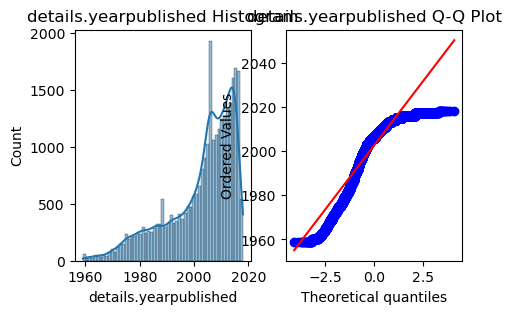

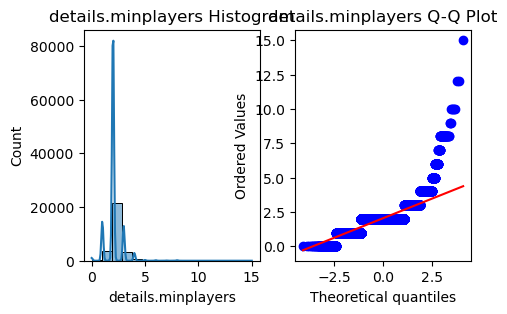

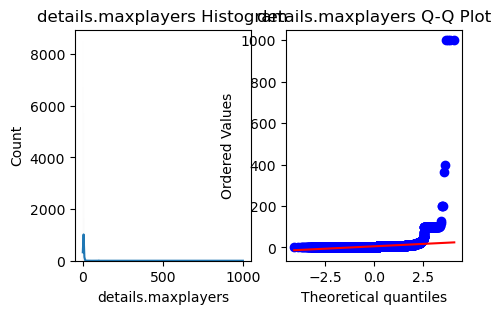

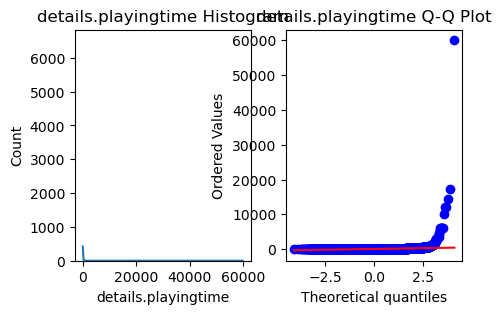

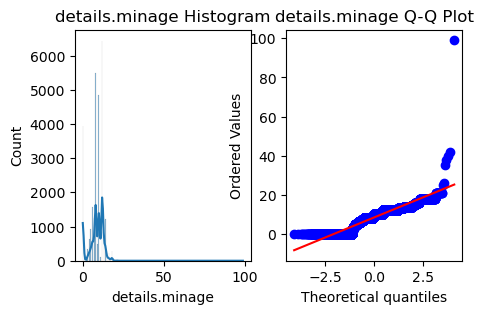

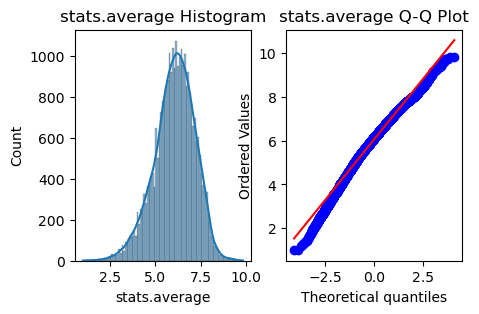

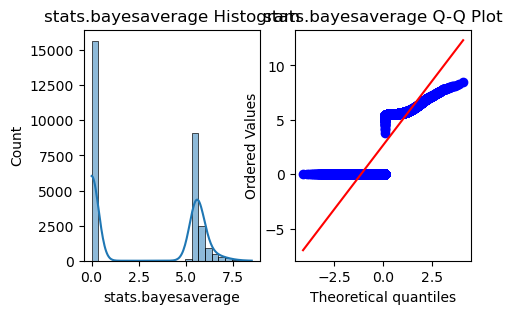

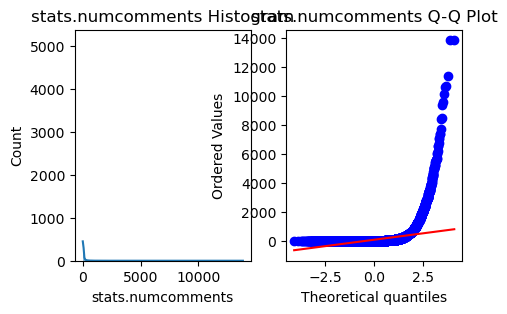

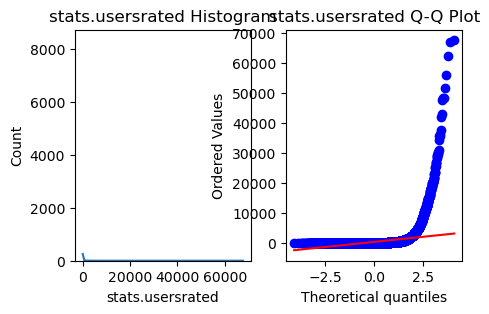

In [31]:
for col in num_cols:
    plt.figure(figsize=(5,3))
    
    # Histogram
    plt.subplot(1,2,1)
    sns.histplot(topics_df[col], kde=True)
    plt.title(f"{col} Histogram")
    
    # Q-Q plot
    plt.subplot(1,2,2)
    stats.probplot(topics_df[col], dist="norm", plot=plt)
    plt.title(f"{col} Q-Q Plot")
    
    plt.show()

In [32]:
### only the stats_average is closest to normal... so i don't apply outliers for it bcz there is no nneed apply outlier on stats_average

In [33]:
## outliers apply for numeric which seems non-normal
num_cols = ["details.yearpublished","details.minplayers","details.maxplayers","details.playingtime","details.minage",
            "stats.bayesaverage","stats.numcomments","stats.usersrated"]
for col in num_cols:
    Q1=topics_df[col].quantile(0.25)
    Q3=topics_df[col].quantile(0.75)
    IQR=Q3-Q1
    lower=Q1 - 1.5*IQR
    upper=Q3 + 1.5*IQR
    outliers=topics_df[(topics_df[col]<lower) | (topics_df[col]>upper)]
    print(f"{col}:{len(outliers)} outliers")

details.yearpublished:640 outliers
details.minplayers:7904 outliers
details.maxplayers:646 outliers
details.playingtime:2674 outliers
details.minage:7 outliers
stats.bayesaverage:0 outliers
stats.numcomments:4102 outliers
stats.usersrated:4410 outliers


In [34]:
### i think so capping is good here it works well with skewed num colss....nd keep all rowss 
for col in num_cols:
    Q1=topics_df[col].quantile(0.25)
    Q3=topics_df[col].quantile(0.75)
    IQR=Q3-Q1
    lower=Q1 - 1.5*IQR
    upper=Q3 + 1.5*IQR
    topics_df[col]=np.where(topics_df[col]<lower,lower,topics_df[col])
    topics_df[col]=np.where(topics_df[col]>upper,upper,topics_df[col])

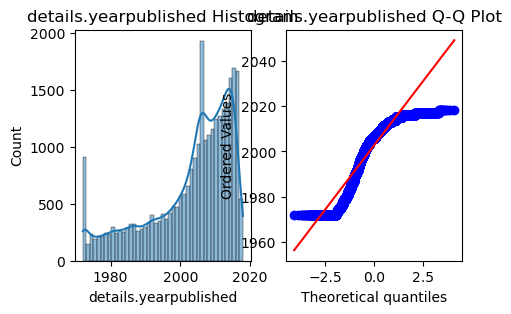

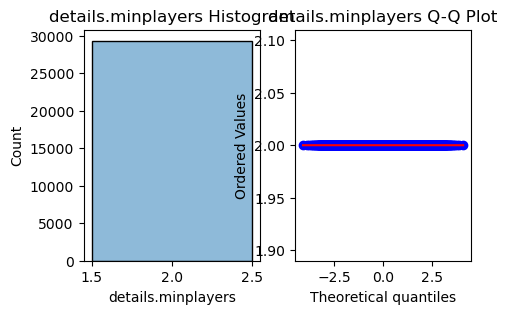

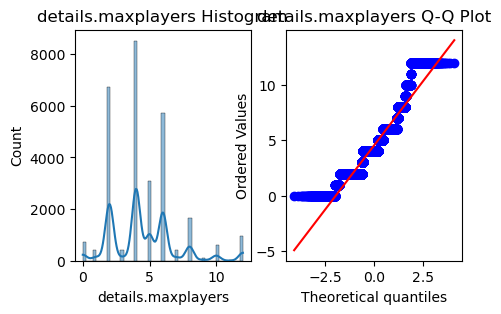

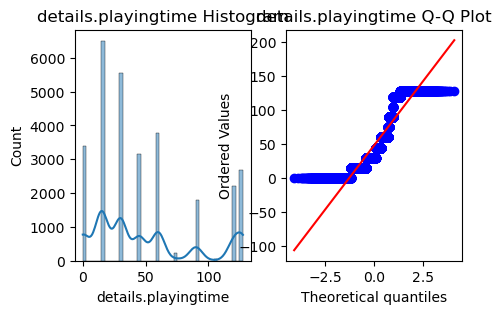

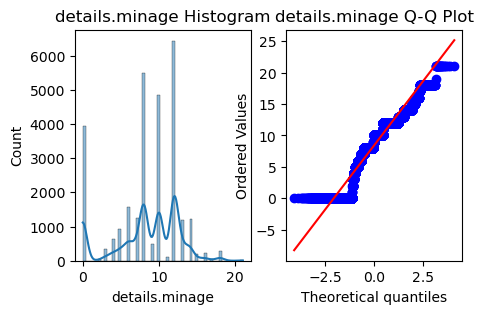

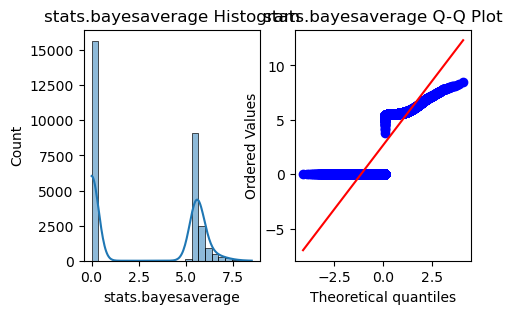

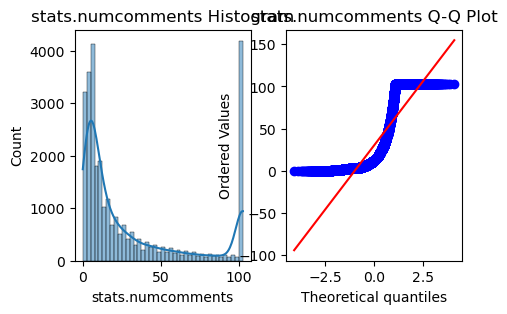

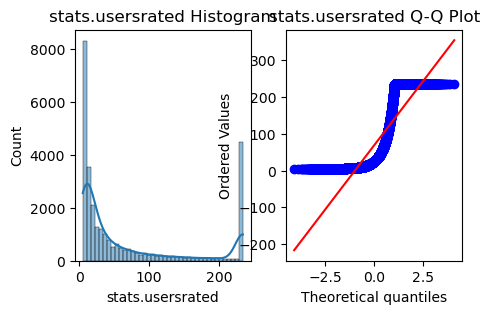

In [35]:
###chexk again 
for col in num_cols:
    plt.figure(figsize=(5,3))
    
    # Histogram
    plt.subplot(1,2,1)
    sns.histplot(topics_df[col], kde=True)
    plt.title(f"{col} Histogram")
    
    # Q-Q plot
    plt.subplot(1,2,2)
    stats.probplot(topics_df[col], dist="norm", plot=plt)
    plt.title(f"{col} Q-Q Plot")
    
    plt.show()

In [36]:
## after outlier handling,extreme values in mumeric cols have been capped
# This data is suitable for ETL and analysis in Postgresql without further transformations

In [37]:
## handle duplicate if exists
topics_df.duplicated().sum()

0

In [38]:
##move to next table

In [39]:
board_ldaOut_topics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29229 entries, 0 to 29228
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   row_names           29229 non-null  object
 1   topics(bgg.ldaOut)  29229 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 456.8+ KB


In [40]:
## handle duplicate  if exists
board_ldaOut_topics.duplicated().sum()

0

In [41]:
#this board_topics table only contains topic assignments (integers) for each game....
# here’s no continuous numeric variable here, so normality testing, outlier detection, or capping is not applicable.....
#It will be used as categorical/identifier data in analysis and PostgreSQL...

In [42]:
# next table

In [43]:
board_ldaOut_top_terms.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   row_names  250 non-null    int64  
 1   topic      250 non-null    int64  
 2   term       250 non-null    object 
 3   beta       250 non-null    float64
dtypes: float64(1), int64(2), object(1)
memory usage: 7.9+ KB


In [44]:
### in this tabke we also don't need check nor,ality nd outliers, there is also a numericcol (beta_) but it repersenrt normality not a measurement.

In [45]:
## handle duplicate  if exists 
board_ldaOut_top_terms.duplicated().sum()

0

In [46]:
### next and the last table of this dataset

In [47]:
board_ldaOut_top_documents.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 288 entries, 0 to 287
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   row_names  288 non-null    int64  
 1   document   288 non-null    object 
 2   topic      288 non-null    int64  
 3   gamma      288 non-null    float64
dtypes: float64(1), int64(2), object(1)
memory usage: 9.1+ KB


In [48]:
###this table contains document topic assignments with probailistic gamma values....
# since these are derived frm lda outputs and represent  proportion,no normality or outlier check are performed
# the data is directly used for analysis nd postgresql integration 

In [49]:
## handle duplicate  if exists 
board_ldaOut_top_documents.duplicated().sum()

0

In [67]:
### Now all tables are cleaned and handled
import csv

#### Export cleaned data in the csv file 


In [68]:
games_df.to_csv(r"C:\Users\Asus\OneDrive\Desktop\Board_game postgrsql project\data\cleaned_data\board_games_clean.csv",index=False)
topics_df.to_csv(r"C:\Users\Asus\OneDrive\Desktop\Board_game postgrsql project\data\cleaned_data\board_topics_clean.csv",index=False)
board_ldaOut_topics.to_csv(r"C:\Users\Asus\OneDrive\Desktop\Board_game postgrsql project\data\cleaned_data\board_ldaOut_topics_clean.csv",index=False)
board_ldaOut_top_terms.to_csv(r"C:\Users\Asus\OneDrive\Desktop\Board_game postgrsql project\data\cleaned_data\board_ldaOut_top_terms_clean.csv",index=False)
board_ldaOut_top_documents.to_csv(r"C:\Users\Asus\OneDrive\Desktop\Board_game postgrsql project\data\cleaned_data\board_ldaOut_top_documents=_clean.csv",index=False)


In [69]:
### Connect with postgresql
conn=psycopg2.connect(
    host="localhost",
    database="Board_Games_project",
    user="postgres",
    password="Priyanshi123",
    port="5432"
)
cursor=conn.cursor()
print("Connection successfully")

Connection successfully


In [70]:
df=pd.read_csv(r"C:\Users\Asus\OneDrive\Desktop\Board_game postgrsql project\data\cleaned_data\board_games_clean.csv")
df2=pd.read_csv(r"C:\Users\Asus\OneDrive\Desktop\Board_game postgrsql project\data\cleaned_data\board_topics_clean.csv")
df3=pd.read_csv(r"C:\Users\Asus\OneDrive\Desktop\Board_game postgrsql project\data\cleaned_data\board_ldaOut_top_documents=_clean.csv")
df4=pd.read_csv(r"C:\Users\Asus\OneDrive\Desktop\Board_game postgrsql project\data\cleaned_data\board_ldaOut_top_terms_clean.csv")
df5=pd.read_csv(r"C:\Users\Asus\OneDrive\Desktop\Board_game postgrsql project\data\cleaned_data\board_ldaOut_topics_clean.csv")


In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90400 entries, 0 to 90399
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   game_id         90400 non-null  int64  
 1   name            90400 non-null  object 
 2   year_published  90400 non-null  float64
 3   min_players     90400 non-null  float64
 4   max_players     90400 non-null  float64
 5   min_age         90400 non-null  float64
 6   playing_time    90400 non-null  float64
 7   average_rating  90400 non-null  float64
 8   bayes_average   90400 non-null  float64
 9   num_ratings     90400 non-null  float64
 10  complexity      90400 non-null  float64
 11  publisher       90400 non-null  object 
dtypes: float64(9), int64(1), object(2)
memory usage: 8.3+ MB


In [72]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29313 entries, 0 to 29312
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   game.id                29313 non-null  int64  
 1   details.name           29313 non-null  object 
 2   details.yearpublished  29313 non-null  float64
 3   details.minplayers     29313 non-null  float64
 4   details.maxplayers     29313 non-null  float64
 5   details.playingtime    29313 non-null  float64
 6   details.minage         29313 non-null  float64
 7   stats.average          29313 non-null  float64
 8   stats.bayesaverage     29313 non-null  float64
 9   stats.numcomments      29313 non-null  float64
 10  stats.usersrated       29313 non-null  float64
 11  topic                  29313 non-null  object 
dtypes: float64(9), int64(1), object(2)
memory usage: 2.7+ MB


In [73]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 288 entries, 0 to 287
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   row_names  288 non-null    int64  
 1   document   288 non-null    object 
 2   topic      288 non-null    int64  
 3   gamma      288 non-null    float64
dtypes: float64(1), int64(2), object(1)
memory usage: 9.1+ KB


In [74]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   row_names  250 non-null    int64  
 1   topic      250 non-null    int64  
 2   term       250 non-null    object 
 3   beta       250 non-null    float64
dtypes: float64(1), int64(2), object(1)
memory usage: 7.9+ KB


In [75]:
df5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29229 entries, 0 to 29228
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   row_names           29229 non-null  object
 1   topics(bgg.ldaOut)  29229 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 456.8+ KB


In [76]:
### i would insert data by copy function in postgresql let'see 

In [77]:
tables_csv={
   "board_games":r"C:\Users\Asus\OneDrive\Desktop\Board_game postgrsql project\data\cleaned_data\board_games_clean.csv",
   "board_topics":r"C:\Users\Asus\OneDrive\Desktop\Board_game postgrsql project\data\cleaned_data\board_topics_clean.csv",
   "board_ldaOut_top_documents":r"C:\Users\Asus\OneDrive\Desktop\Board_game postgrsql project\data\cleaned_data\board_ldaOut_top_documents=_clean.csv",
   "board_ldaOut_top_terms":r"C:\Users\Asus\OneDrive\Desktop\Board_game postgrsql project\data\cleaned_data\board_ldaOut_top_terms_clean.csv",
   "board_ldaOut_topics":r"C:\Users\Asus\OneDrive\Desktop\Board_game postgrsql project\data\cleaned_data\board_ldaOut_topics_clean.csv"
}
for table,csv_file in tables_csv.items():
    with open(csv_file, 'r', encoding='utf-8') as f:
        reader = csv.reader(f)
        headers = next(reader)  # skip header
        for row in reader:
            # Prepare INSERT with placeholders
            cursor.execute(
                f"INSERT INTO {table} VALUES ({','.join(['%s']*len(row))})",
                row
            )
    print(f"{table} inserted successfully!")

conn.commit()
cursor.close()
conn.close()
print("All tables inserted successfully!")


board_games inserted successfully!
board_topics inserted successfully!
board_ldaOut_top_documents inserted successfully!
board_ldaOut_top_terms inserted successfully!
board_ldaOut_topics inserted successfully!
All tables inserted successfully!
